**Colab 4: Autoencoders!**

In this colab we'll use the classsssic MNIST dataset of tiny black and white handwritten digits to make some cool autoencoders, which let us learn a low dimensional representation for images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tfkl = tf.keras.layers

In [ ]:
dset_train, dset_test = tfds.load('mnist', split=['train', 'test'])
dset_with_labels = dset_train.map(lambda example: (tf.image.convert_image_dtype(example['image'], tf.float32), example['label']))
dset_images_only = dset_train.map(lambda example: tf.image.convert_image_dtype(example['image'], tf.float32))
dset_test = dset_test.map(lambda example: (tf.image.convert_image_dtype(example['image'], tf.float32), example['label']))

# Regular old autoencoder

First we just encode and then decode, with the knowledge that the reconstruction should match the original.  Cool way to learn a lower-dimensional representation.

In [ ]:
def make_mnist_encoder(num_latent_dims):
  # TODO: Make a sequential model that takes a (28, 28, 1) tensor as input
  # 1st layer: convolution with 32 filters, size 3x3, relu activation, stride of 2, and 'same' padding
  # 2nd layer: same, but 64 filters
  # 3rd layer: flatten 
  # 4th layer: fully connected (dense) w 16 units, relu activation
  # 5th (final) layer: fully connected layer with num_latent_dims units, no activation (linear)
  enc = ######
  return enc
def make_mnist_decoder(num_latent_dims):
  # TODO: Make a sequential model that takes a (num_latent_dims,) tensor as input
  # 1st layer: fully connected with 7 * 7 * 64 units, relu activation
  # 2nd layer: reshape, into a 7x7 array with 64 dimensions (tensor shape [7, 7, 64])
  # 3rd layer: transpose convolution with 64 filters, size 3x3, relu activation, stride of 2, and 'same' padding 
  # 4th layer: same but 32 filters
  # 5th (final) layer: transpose convolution with 1 filter, size 3x3, sigmoid activation, and 'same' padding
  dec = ##########
  return dec

In [ ]:
# It's important that the decoder final size matches the encoder input size, so some fine tuning is required if you make any changes
# besides to the number of latent dimensions
num_latent_dims = 8
enc = make_mnist_encoder(num_latent_dims)
dec = make_mnist_decoder(num_latent_dims)
print(enc.summary())
print(dec.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                50192     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 69,144
Trainable params: 69,144
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)             

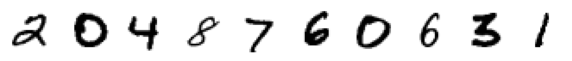

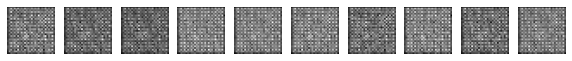

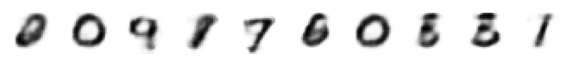

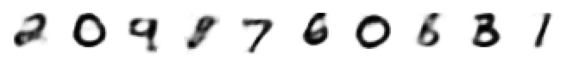

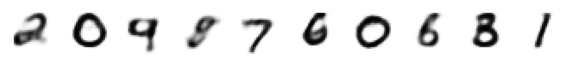

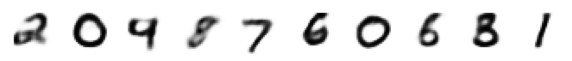

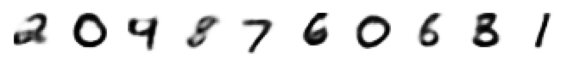

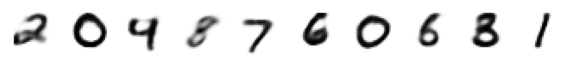

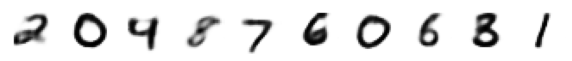

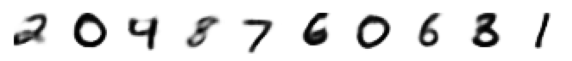

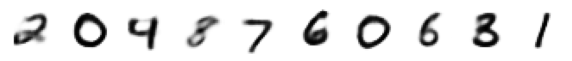

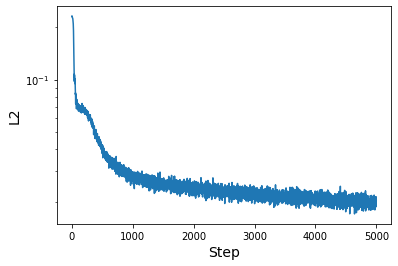

In [ ]:
bs = 128  # batch size
lr = 3e-4  # learning rate
num_training_steps = 5000
opt = tf.keras.optimizers.Adam(lr)
l_l2 = []  # L2 loss tracker
num_sample_images = 10
cmap_raw = cm.binary

# Plot some images from the test set, and watch the reconstruction quality over time
sample_images = next(iter(dset_test.batch(num_sample_images)))[0]
plt.figure(figsize=(num_sample_images, 1))
for i in range(num_sample_images):
  plt.subplot(1, num_sample_images, i+1)
  plt.imshow(sample_images[i, ..., 0], cmap=cmap_raw)
  plt.axis('off')
plt.show()

# Wrap the training step in this magical @tf.function wrapper so that the computation is compiled --> faster
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    embs = enc(images)  # Embed the images
    decoded = dec(embs)  # Decode them again
    l2_term =  # TODO: The loss is just the mean squared error per pixel
    loss = l2_term
  grads = tape.gradient(loss, enc.trainable_variables+dec.trainable_variables)  # Compute and apply the gradients to both the encoder and decoder (full stack)
  opt.apply_gradients(zip(grads, enc.trainable_variables+dec.trainable_variables))
  return l2_term

for step, images in enumerate(dset_images_only.repeat().shuffle(10_000).batch(bs).take(num_training_steps)):
  l2_term = train_step(images)
  l_l2.append(l2_term.numpy())
  # Display the reconstructed sample images 10x during training
  if step % (num_training_steps//10) == 0:
    sample_decoded = dec(enc(sample_images))
    plt.figure(figsize=(num_sample_images, 1))
    for i in range(num_sample_images):
      plt.subplot(1, num_sample_images, i+1)
      plt.imshow(sample_decoded[i, ..., 0], cmap=cmap_raw)
      plt.axis('off')
    plt.show()

plt.plot(l_l2)
plt.xlabel('Step', fontsize=14)
plt.ylabel('L2', fontsize=14)
plt.yscale('log')
plt.show()

PCA variance ratio: [0.34428032 0.19029429 0.14782845 0.10530633 0.08520023 0.06541057
 0.03650815 0.02517166]


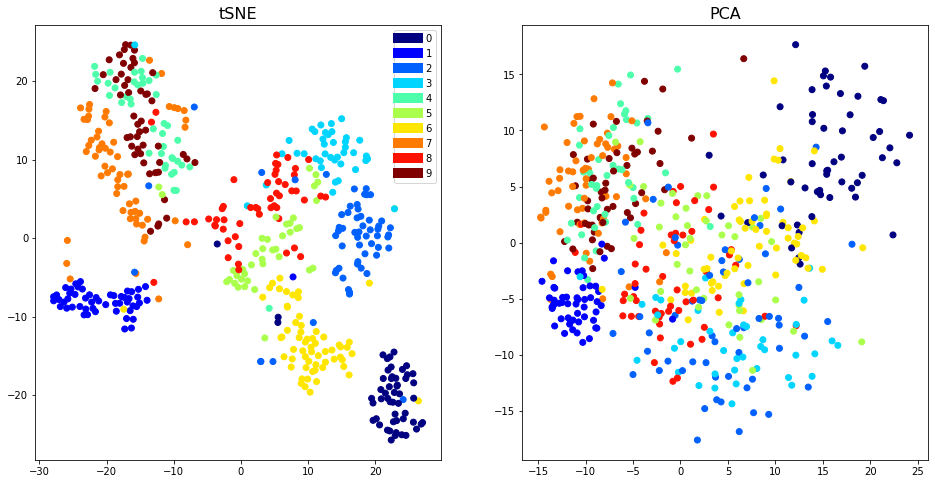

In [ ]:
# Run t-SNE on the embedding space
# And then do PCA
# Use the test dataset
num_test_images = 512
test_bs = 128
test_images, test_embs, test_labels = [[] for _ in range(3)]
# Embed them all, keep the labels for coloring
for images, labels in dset_test.batch(test_bs).take(num_test_images//test_bs):
  test_images.append(images)
  test_embs.append(enc(images))
  test_labels.append(labels)

test_images = tf.concat(test_images, 0)
test_embs = tf.concat(test_embs, 0)
test_labels = tf.concat(test_labels, 0)


cmap_latent = cm.jet
plt.figure(figsize=(16, 8))
plt.subplot(121)
projected_embs = TSNE(n_components=2).fit_transform(test_embs)
plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
[plt.plot(0, 0, color=cmap_latent(digit/9.), label=digit, lw=10) for digit in range(10)]
plt.title('tSNE', fontsize=16)
plt.legend()

plt.subplot(122)
pca = PCA()
projected_embs = pca.fit_transform(test_embs)
print('PCA variance ratio:', pca.explained_variance_ratio_)
plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
plt.title('PCA', fontsize=16)

plt.show()

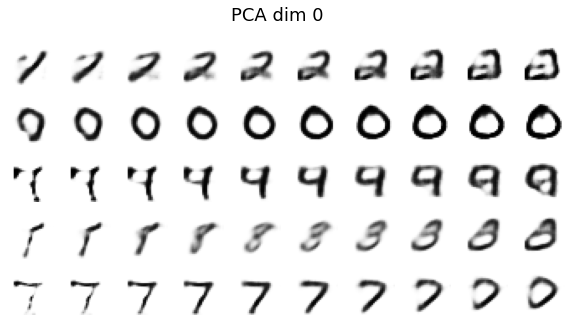

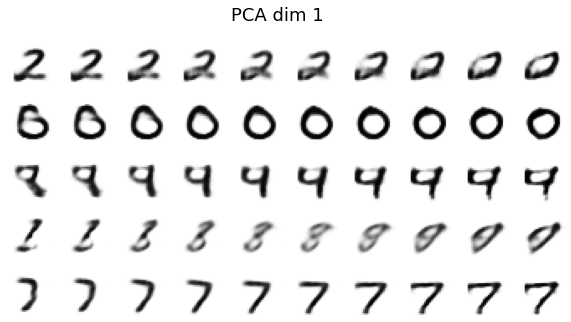

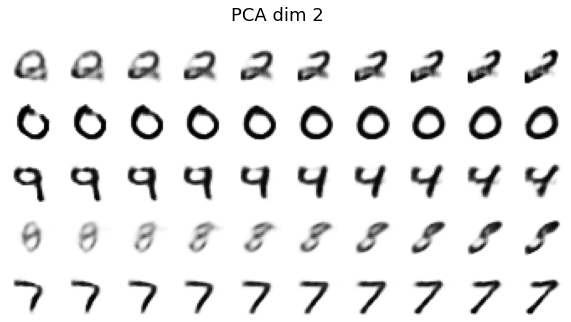

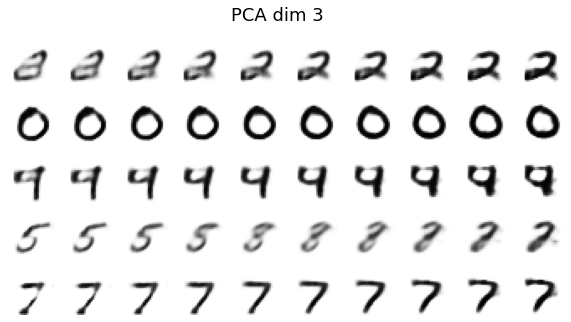

In [ ]:
# Latent traversal -- move along lines in latent space and visualize the output
# Pick an emb, then move along the first couple of PCA dimensions
num_seed_pts = 5
seed_pts = range(num_seed_pts)
num_pca_dims = 4
num_latent_steps_per = 10
inches_per_subplot = 1
for pca_dim in range(num_pca_dims):
  pca_vec = pca.components_[pca_dim]
  pca_vec_extent = 2*np.sqrt(pca.explained_variance_[pca_dim])
  plt_images = []
  ## Step along the pca_vec in latent space, and decode along the way
  for latent_step in np.linspace(-pca_vec_extent, pca_vec_extent, num_latent_steps_per):
    new_images = dec(test_embs[:num_seed_pts]+pca_vec*latent_step)
    plt_images.append(new_images)
  plt_images = tf.stack(plt_images, 0)
  plt.figure(figsize=((num_latent_steps_per)*inches_per_subplot, num_seed_pts*inches_per_subplot))
  plt_ind = 1
  for image_ind in seed_pts: 
    for latent_step in range(num_latent_steps_per):
      plt.subplot(num_seed_pts, num_latent_steps_per, plt_ind)
      plt.imshow(plt_images[latent_step, image_ind, ..., 0], cmap_raw, vmin=0, vmax=1)
      plt.axis('off')
      plt_ind+=1
  plt.suptitle(f'PCA dim {pca_dim}', fontsize=18)
  plt.show()

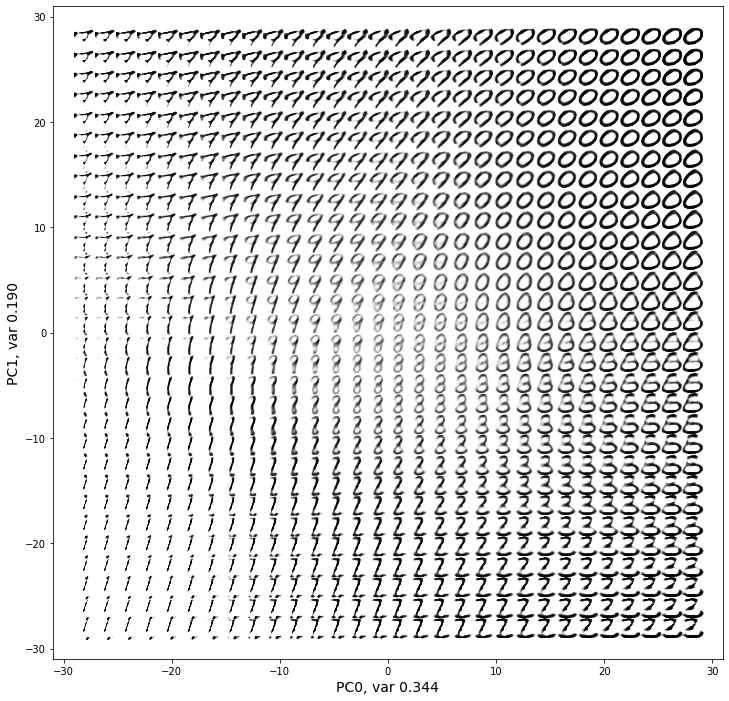

In [ ]:
# Explore a patch instead of a line in latent space; visualize a grid over the first two PCA dims
plt.figure(figsize=(12, 12))
image_zoom_factor = 1.  # scales the size of the individual digit images
latent_scale = 3*np.sqrt(pca.explained_variance_[0])
num_latent_steps_per = 30
gridx, gridy = np.meshgrid(np.linspace(-1, 1, num_latent_steps_per),
                           np.linspace(-1, 1, num_latent_steps_per))
gridx = np.reshape(gridx, [-1, 1])*latent_scale
gridy = np.reshape(gridy, [-1, 1])*latent_scale
grid_pts = np.stack([gridx, gridy], -1).reshape([-1, 2])
embs = gridx*pca.components_[0] + gridy*pca.components_[1]
# Add the mean of the embeddings back as the origin of this grid
embs += tf.reduce_mean(test_embs, axis=0, keepdims=True)
plt_images = dec(embs)

ax = plt.gca()
for image_id, image in enumerate(plt_images):
  image = tf.clip_by_value(tf.concat([1-image, 1-image, 1-image, image], -1), 0, 1)
  im = OffsetImage(image, zoom=image_zoom_factor)
  ab = AnnotationBbox(im, grid_pts[image_id], frameon=False)
  ax.add_artist(ab)
  plt.scatter(grid_pts[image_id, 0], grid_pts[image_id, 1], s=0)  # this is just so the axes bound the images
plt.xlabel('PC0, var {:.3f}'.format(pca.explained_variance_ratio_[0]), fontsize=14.)
plt.ylabel('PC1, var {:.3f}'.format(pca.explained_variance_ratio_[1]), fontsize=14.)

plt.show()

# Variational autoencoder (VAE)

There are a plethora of great resources out there with different insights into VAEs.  My grain of salt intuition is that they improve upon vanilla autoencoders by conditioning the latent space even further: VAEs have an extra loss term that encourages the embeddings to 'fill' a unit Gaussian in latent space.  Thought of in terms of rate-distortion theory / sending a signal through a noisy channel, we can think of the latent space as a channel through which to send the necessary info to reconstruct the input image.  VAEs set the channel as a unit Gaussian (referred to as the prior) and then each embedding gets turned into a distribution, giving it 'volume' in the channel.  Distortion is still measured by way of a reconstruction loss, but the rate is now introduced as a KL divergence between the embedding and the prior.  We shift along the rate-distortion curve with a parameter beta -- smaller beta prioritizes better reconstruction, and larger beta prioritizes packing the channel more densely/lowering the 'bit rate'.

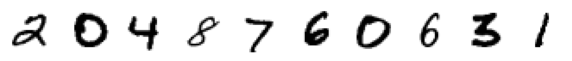

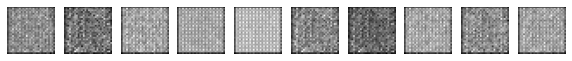

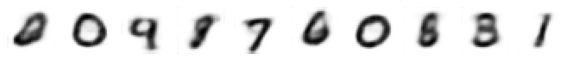

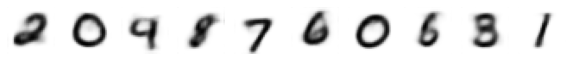

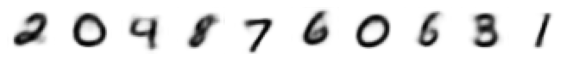

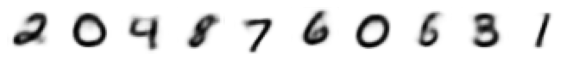

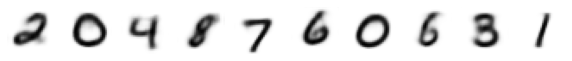

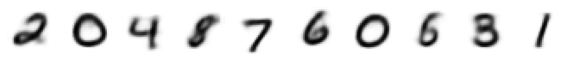

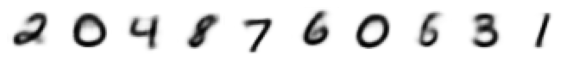

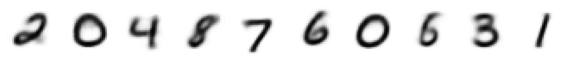

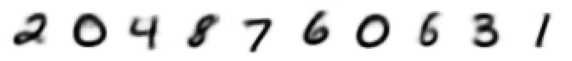

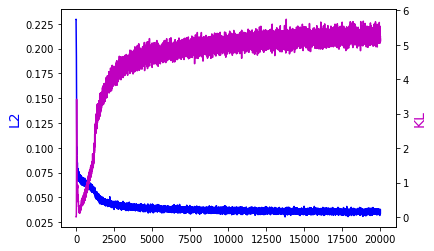

In [ ]:
num_latent_dims = 8
enc = make_mnist_encoder(num_latent_dims*2) # Make an encoder with 2x as many dimensions: we'll use the first half as the center of the Gaussian representing the embedding, and the second half as the log of the variance vector
dec = make_mnist_decoder(num_latent_dims) # The decoder is unchanged

sample_images = next(iter(dset_test.batch(num_sample_images)))[0]
plt.figure(figsize=(num_sample_images, 1))
for i in range(num_sample_images):
  plt.subplot(1, num_sample_images, i+1)
  plt.imshow(sample_images[i, ..., 0], cmap=cmap_raw)
  plt.axis('off')
plt.show()

bs = 128
beta = 3e-3 # This is kind of a weird value for reasons we'll get into on Thursday; try changing by a factor of ~3 in either direction and you should already see different behavior
lr = 3e-4
num_steps = 20_000
opt = tf.keras.optimizers.Adam(lr)

@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    embs = enc(images)
    mus, logvars = tf.split(embs, 2, axis=-1)  # This defines a Gaussian w diagonal covariance matrix for each embedding
    kl_term = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mus) + tf.exp(logvars) - logvars - 1., axis=-1))  # The KL divergence term mentioned above, between the prior and the embedding distribution
    reparameterized_embs = ### TODO: sample from the Gaussians defined by mus and logvars to get the embedding to pass to the decoder (using tf.random.normal())
    decoded = dec(reparameterized_embs)
    l2_term = tf.reduce_mean(tf.square(decoded - images))
    loss = l2_term + beta * kl_term
  grads = tape.gradient(loss, enc.trainable_variables+dec.trainable_variables)
  opt.apply_gradients(zip(grads, enc.trainable_variables+dec.trainable_variables))
  return l2_term, kl_term

l_kl, l_l2 = [[], []]
for step, images in enumerate(dset_images_only.repeat().shuffle(10_000).batch(bs).take(num_steps)):
  l2_term, kl_term = train_step(images)
  l_kl.append(kl_term.numpy())
  l_l2.append(l2_term.numpy())
  if step % (num_steps//10) == 0:
    decoded = dec(enc(sample_images)[..., :num_latent_dims])
    plt.figure(figsize=(num_sample_images, 1))
    for i in range(num_sample_images):
      plt.subplot(1, num_sample_images, i+1)
      plt.imshow(decoded[i, ..., 0], cmap=cmap_raw)
      plt.axis('off')
    plt.show()

plt.plot(l_l2, 'b')
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(l_kl, 'm')
plt.xlabel('Step', fontsize=14)
ax.set_ylabel('L2', color='b', fontsize=14)
ax2.set_ylabel('KL', color='m', fontsize=14)
plt.show()

PCA variance ratio: [2.38681055e-01 2.28800574e-01 2.08939924e-01 1.77065107e-01
 1.46320895e-01 1.77120994e-04 1.53240321e-05 2.32186753e-18]


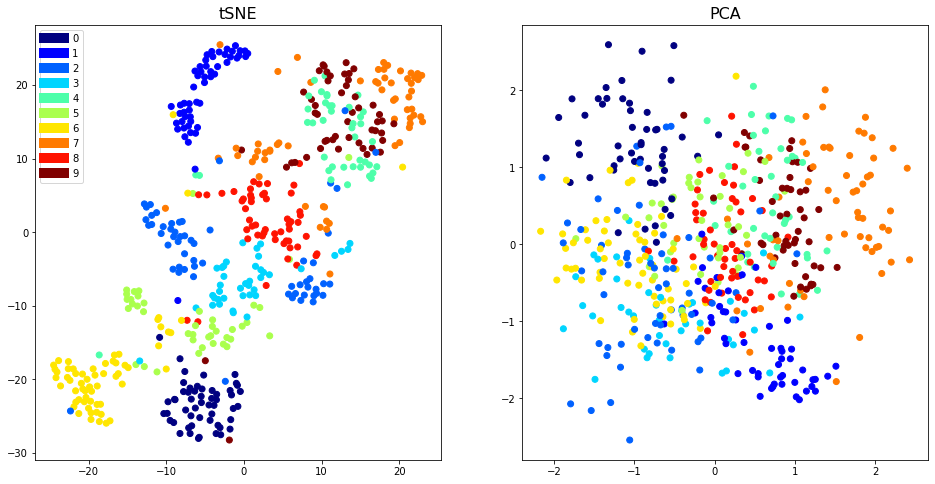

In [ ]:
# tSNE and PCA again
num_test_images = 512
test_bs = 128
test_images, test_embs, test_labels = [[] for _ in range(3)]
# Embed them all, keep the labels for coloring
for images, labels in dset_test.batch(test_bs).take(num_test_images//test_bs):
  test_images.append(images)
  test_embs.append(enc(images)[..., :num_latent_dims])
  test_labels.append(labels)

test_images = tf.concat(test_images, 0)
test_embs = tf.concat(test_embs, 0)
test_labels = tf.concat(test_labels, 0)


cmap_latent = cm.jet
plt.figure(figsize=(16, 8))
plt.subplot(121)
projected_embs = TSNE(n_components=2).fit_transform(test_embs)
plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
[plt.plot(0, 0, color=cmap_latent(digit/9.), label=digit, lw=10) for digit in range(10)]
plt.title('tSNE', fontsize=16)
plt.legend()

plt.subplot(122)
pca = PCA()
projected_embs = pca.fit_transform(test_embs)
print('PCA variance ratio:', pca.explained_variance_ratio_)
plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
plt.title('PCA', fontsize=16)

plt.show()

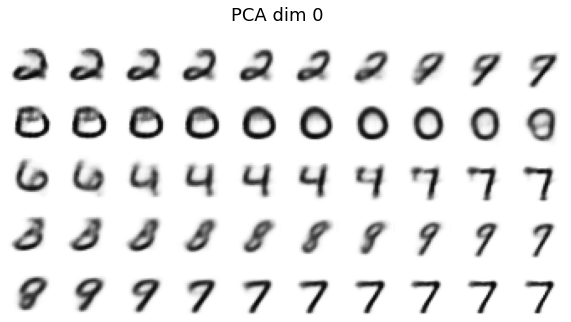

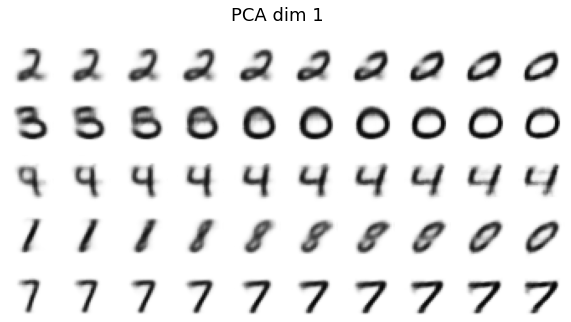

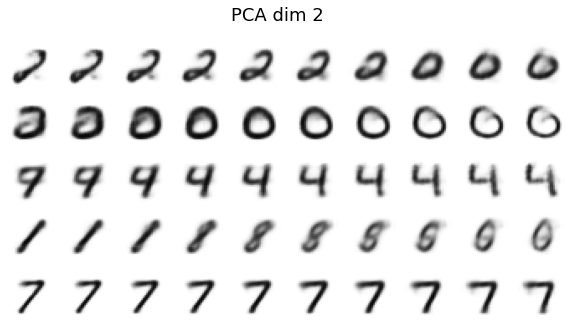

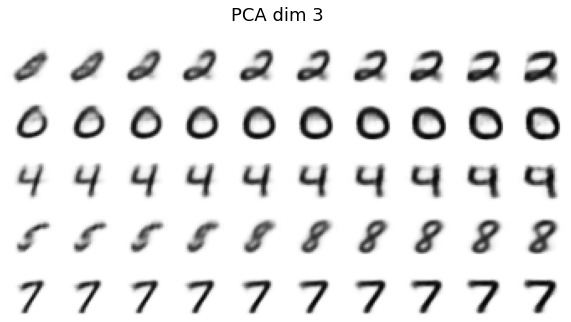

In [ ]:
# Latent traversal
# Pick an emb, then move along the first couple of PCA dimensions.  Now we know the center of embedding space is the origin, and the length scale is O(1) to match the prior 
num_seed_pts = 5
seed_pts = range(num_seed_pts)
num_pca_dims = 4
num_latent_steps_per = 10
inches_per = 1
for pca_dim in range(num_pca_dims):
  pca_vec = pca.components_[pca_dim]
  pca_vec_extent = 2
  plt_images = []
  ## Step along the pca_vec in latent space, and decode along the way
  for latent_step in np.linspace(-pca_vec_extent, pca_vec_extent, num_latent_steps_per):
    new_images = dec(test_embs[:num_seed_pts]+pca_vec*latent_step)
    plt_images.append(new_images)
  plt_images = tf.stack(plt_images, 0)
  plt.figure(figsize=((num_latent_steps_per)*inches_per, num_seed_pts*inches_per))
  plt_ind = 1
  for image_ind in seed_pts: 
    for latent_step in range(num_latent_steps_per):
      plt.subplot(num_seed_pts, num_latent_steps_per, plt_ind)
      plt.imshow(plt_images[latent_step, image_ind, ..., 0], cmap_raw, vmin=0, vmax=1)
      plt.axis('off')
      plt_ind+=1
  plt.suptitle(f'PCA dim {pca_dim}', fontsize=18)
  plt.show()

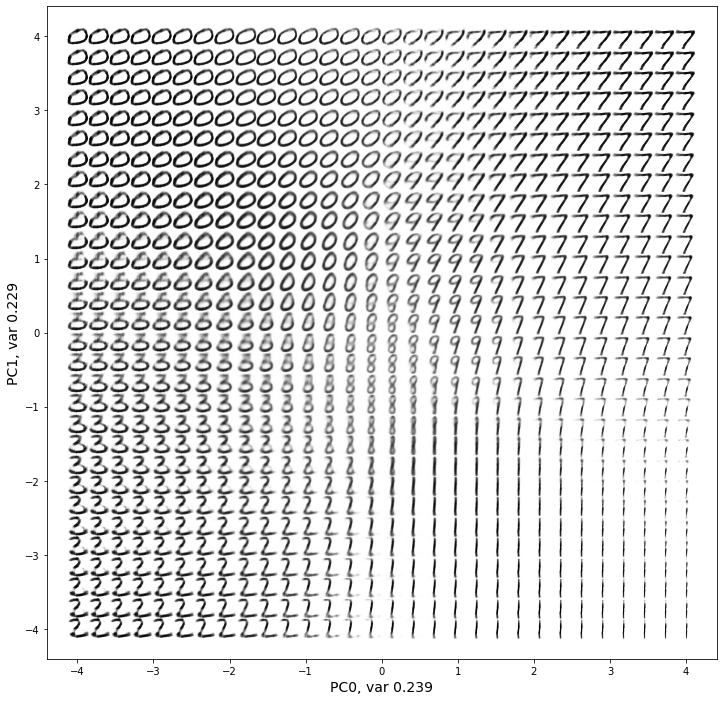

In [ ]:
plt.figure(figsize=(12, 12))
image_zoom_factor = 1.  # scales the size of the individual digit images
latent_scale = 4
num_latent_steps_per = 30
gridx, gridy = np.meshgrid(np.linspace(-1, 1, num_latent_steps_per),
                           np.linspace(-1, 1, num_latent_steps_per))
gridx = np.reshape(gridx, [-1, 1])*latent_scale
gridy = np.reshape(gridy, [-1, 1])*latent_scale
grid_pts = np.stack([gridx, gridy], -1).reshape([-1, 2])
embs = gridx*pca.components_[0] + gridy*pca.components_[1]
plt_images = dec(embs)

ax = plt.gca()
for image_id, image in enumerate(plt_images):
  image = tf.clip_by_value(tf.concat([1-image, 1-image, 1-image, image], -1), 0, 1)
  im = OffsetImage(image, zoom=image_zoom_factor)
  ab = AnnotationBbox(im, grid_pts[image_id], frameon=False)
  ax.add_artist(ab)
  plt.scatter(grid_pts[image_id, 0], grid_pts[image_id, 1], s=0)  # this is just so the axes bound the images
plt.xlabel('PC0, var {:.3f}'.format(pca.explained_variance_ratio_[0]), fontsize=14.)
plt.ylabel('PC1, var {:.3f}'.format(pca.explained_variance_ratio_[1]), fontsize=14.)

plt.show()

# Dueling VAEs, to separate content and style

Finally, we'll play a little game in latent space by using two encoders and pairing up the images by digit (e.g. making pairs of 1s, pairs of 2s, etc).  We know that some information (which we'll call content) should be constant within a pair, and the remaining information (which we'll call style) can vary.  So, generate the content encodings and swap them for each pair before doing the reconstruction (forcing one to be reconstructed from its own style and the others' content).  To encourage using the content channel (it could be ignored, after all), remove the KL loss on the content channel, and boost up the beta a little on the style channel.

In [ ]:
bs = 64
ds = [dset_with_labels.filter(lambda x, y: y==i) for i in range(10)]  # creates 10 datasets, one for each class
ds = [d.map(lambda x, y: x).shuffle(1000).repeat().batch(2) for d in ds]  # drops the label and then pairs up the images
paired_dset = tf.data.experimental.sample_from_datasets(ds).batch(bs)  ## shape is [bs, 2, 28, 28, 1]

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


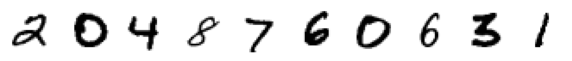

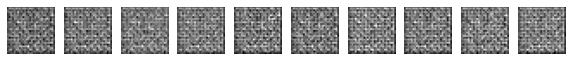

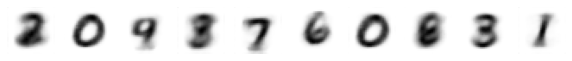

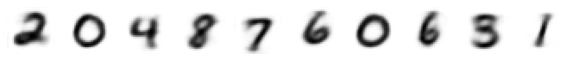

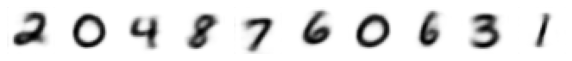

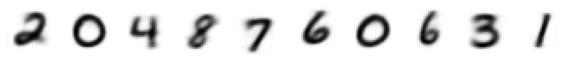

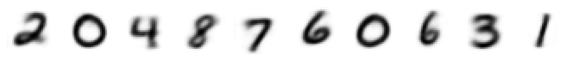

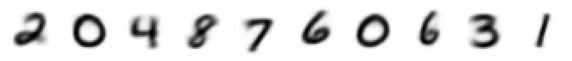

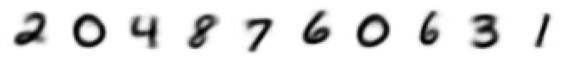

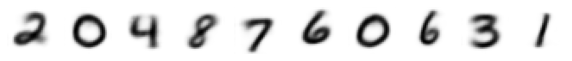

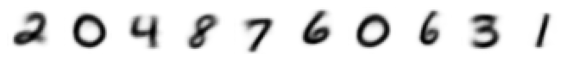

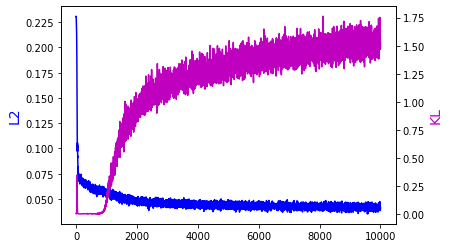

In [ ]:
num_latent_dims = 8
enc_content = make_mnist_encoder(num_latent_dims//2)  # Make this a normal AE, with half of the total dimensions
enc_style = make_mnist_encoder(num_latent_dims)  # This will be a VAE with the other half of the total dimensions
dec = make_mnist_decoder(num_latent_dims)
num_sample_images = 10
cmap_raw = cm.binary
sample_images = next(iter(dset_test.batch(num_sample_images)))[0]
plt.figure(figsize=(num_sample_images, 1))
for i in range(num_sample_images):
  plt.subplot(1, num_sample_images, i+1)
  plt.imshow(sample_images[i, ..., 0], cmap=cmap_raw)
  plt.axis('off')
plt.show()

beta = 5e-3
lr = 3e-4
num_steps = 10000
opt = tf.keras.optimizers.Adam(lr)


@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    embs_content = enc_content(images)

    embs_content = tf.reshape(embs_content, [bs, 2, -1])
    swapped_embs_content = tf.roll(embs_content, 1, axis=1)  # just switches the two content embs for each pair of examples in a batch
    swapped_embs_content = tf.reshape(swapped_embs_content, [-1, num_latent_dims//2])  # reshapes to the right rank

    embs_style = enc_style(images)
    mus_style, logvars_style = tf.split(embs_style, 2, axis=-1)
    reparameterized_embs_style = tf.random.normal(mus_style.shape, mean=mus_style, stddev=tf.exp(logvars_style/2.))
    kl_term_style = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mus_style) + tf.exp(logvars_style) - logvars_style - 1., axis=-1))
    
    reparameterized_embs = tf.concat([swapped_embs_content, reparameterized_embs_style], -1)
    decoded = dec(reparameterized_embs)
    l2_term = tf.reduce_mean(tf.square(decoded - images))
    kl_term = kl_term_style
    loss = l2_term + beta * kl_term

  grads = tape.gradient(loss, enc_content.trainable_variables+enc_style.trainable_variables+dec.trainable_variables)
  opt.apply_gradients(zip(grads, enc_content.trainable_variables+enc_style.trainable_variables+dec.trainable_variables))
  return l2_term, kl_term

l_kl, l_l2 = [[], []]
for step, images in enumerate(paired_dset.take(num_steps)):
  images = tf.reshape(images, [-1, 28, 28, 1])
  l2_term, kl_term = train_step(images)
  l_kl.append(kl_term.numpy())
  l_l2.append(l2_term.numpy())
  
  if step % (num_steps//10) == 0:
    emb_content = enc_content(sample_images)[..., :num_latent_dims//2]
    emb_style = enc_style(sample_images)[..., :num_latent_dims//2]
    decoded = dec(tf.concat([emb_content, emb_style], -1))
    plt.figure(figsize=(num_sample_images, 1))
    for i in range(num_sample_images):
      plt.subplot(1, num_sample_images, i+1)
      plt.imshow(decoded[i, ..., 0], cmap=cmap_raw)
      plt.axis('off')
    plt.show()
plt.plot(l_l2, 'b')
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(l_kl, 'm')
plt.xlabel('Step', fontsize=14)
ax.set_ylabel('L2', color='b', fontsize=14)
ax2.set_ylabel('KL', color='m', fontsize=14)
plt.show()

PCA variance ratio: [0.37690642 0.28842327 0.23542932 0.09924099]


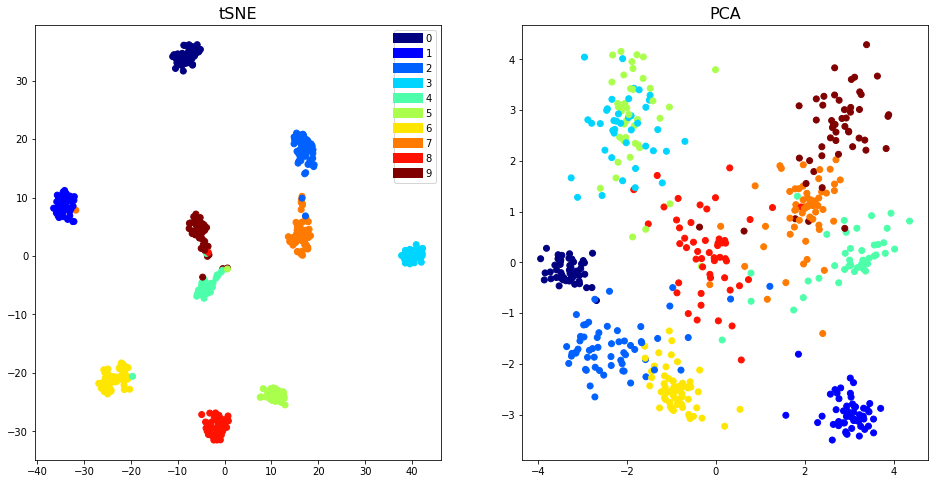

PCA variance ratio: [4.65545568e-01 3.84577552e-01 1.49721018e-01 1.55862445e-04]


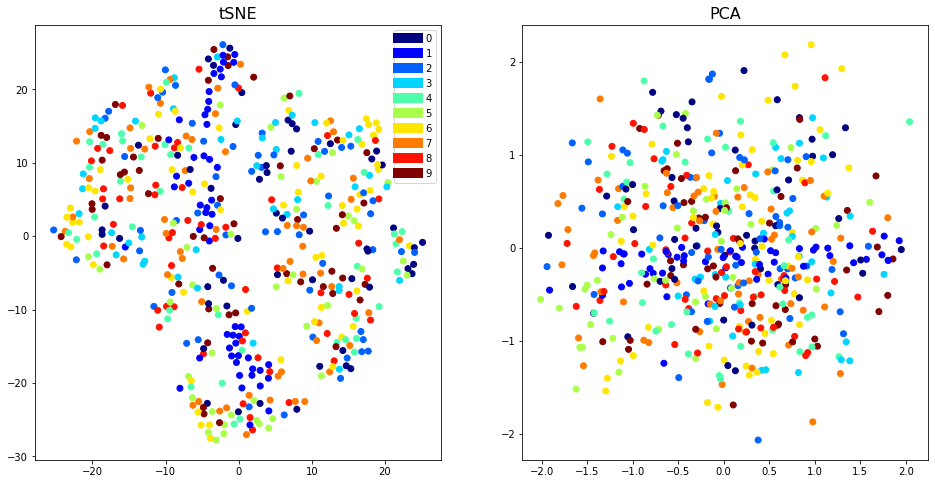

In [ ]:
# We should see the digit info present primarily in the content channel and less so in the style channel
for enc, enc_label in zip([enc_content, enc_style], ['Content', 'Style']):
  num_test_images = 512
  test_bs = 128
  test_images, test_embs, test_labels = [[] for _ in range(3)]
  # Embed them all, keep the labels for coloring
  for images, labels in dset_test.batch(test_bs).take(num_test_images//test_bs):
    test_images.append(images)
    test_embs.append(enc(images)[..., :num_latent_dims//2])
    test_labels.append(labels)

  test_images = tf.concat(test_images, 0)
  test_embs = tf.concat(test_embs, 0)
  test_labels = tf.concat(test_labels, 0)


  cmap_latent = cm.jet
  plt.figure(figsize=(16, 8))
  plt.subplot(121)
  projected_embs = TSNE(n_components=2).fit_transform(test_embs)
  plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
  [plt.plot(0, 0, color=cmap_latent(digit/9.), label=digit, lw=10) for digit in range(10)]
  plt.title('tSNE', fontsize=16)
  plt.legend()

  plt.subplot(122)
  pca = PCA()
  projected_embs = pca.fit_transform(test_embs)
  print('PCA variance ratio:', pca.explained_variance_ratio_)
  plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=test_labels, cmap=cmap_latent)
  plt.title('PCA', fontsize=16)

  plt.suptitle(enc_label, fontsize=20)
  plt.show()

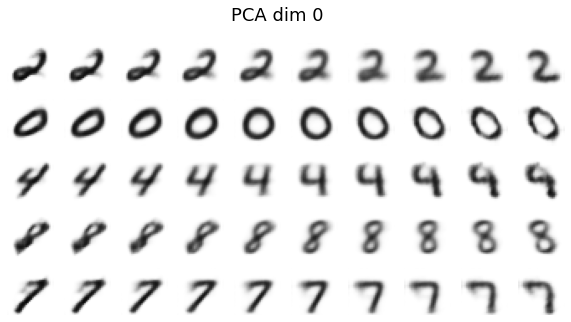

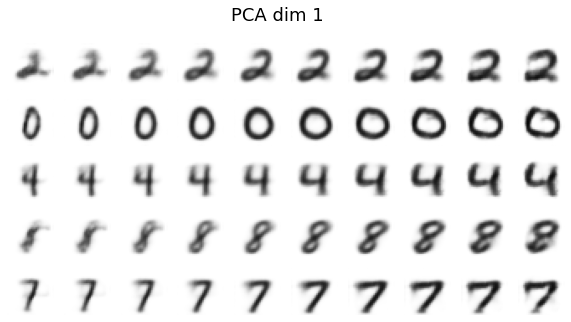

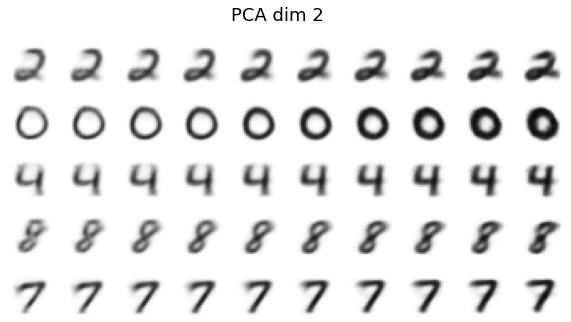

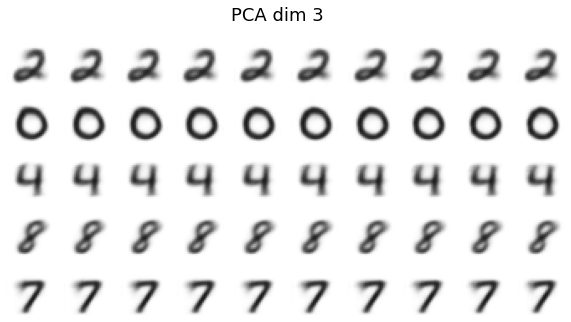

In [ ]:
# The current PCA is the last one evaluated, on the style space -- so do a latent traversal in style space
# Pick an emb, then move along the first couple of PCA dimensions
num_seed_pts = 5
seed_pts = range(num_seed_pts)
content_embs = enc_content(test_images[:num_seed_pts])
num_pca_dims = 4
num_latent_steps_per = 10
inches_per = 1
for pca_dim in range(num_pca_dims):
  pca_vec = pca.components_[pca_dim]
  pca_vec_extent = 4
  plt_images = []
  ## Step along the pca_vec in latent space, and decode along the way
  for latent_step in np.linspace(-pca_vec_extent, pca_vec_extent, num_latent_steps_per):
    concatenated_emb = tf.concat([content_embs, test_embs[:num_seed_pts]+pca_vec*latent_step], -1)
    new_images = dec(concatenated_emb)
    plt_images.append(new_images)
  plt_images = tf.stack(plt_images, 0)
  plt.figure(figsize=((num_latent_steps_per)*inches_per, num_seed_pts*inches_per))
  plt_ind = 1
  for image_ind in seed_pts: 
    for latent_step in range(num_latent_steps_per):
      plt.subplot(num_seed_pts, num_latent_steps_per, plt_ind)
      plt.imshow(plt_images[latent_step, image_ind, ..., 0], cmap_raw, vmin=0, vmax=1)
      plt.axis('off')
      plt_ind+=1
  plt.suptitle(f'PCA dim {pca_dim}', fontsize=18)
  plt.show()

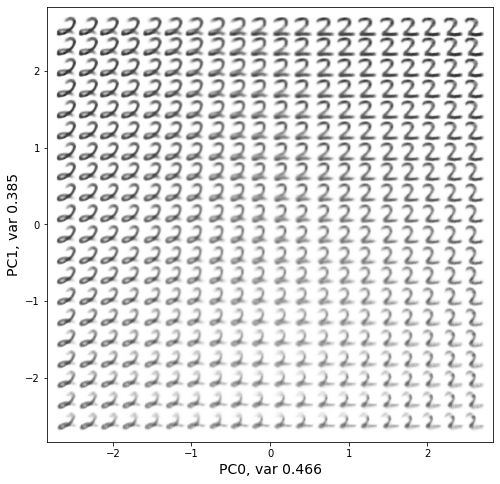

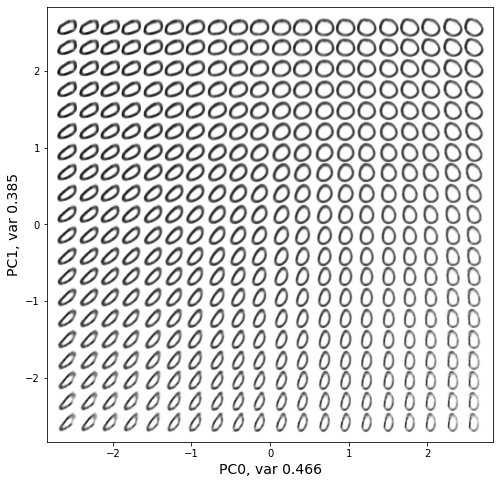

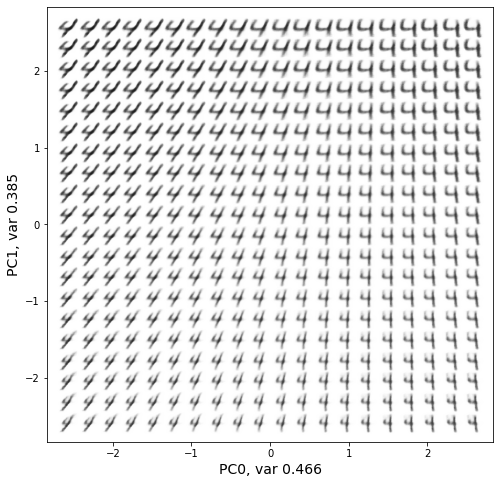

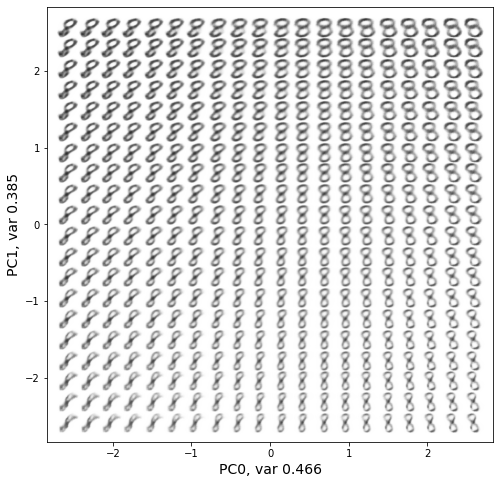

In [ ]:
for test_image_id in range(4):
  content_embs = enc_content(test_images[test_image_id][tf.newaxis])
  plt.figure(figsize=(8, 8))
  image_zoom_factor = 1.  # scales the size of the individual digit images
  latent_scale = 3*np.sqrt(pca.explained_variance_[0])
  num_latent_steps_per = 20
  gridx, gridy = np.meshgrid(np.linspace(-1, 1, num_latent_steps_per),
                            np.linspace(-1, 1, num_latent_steps_per))
  gridx = np.reshape(gridx, [-1, 1])*latent_scale
  gridy = np.reshape(gridy, [-1, 1])*latent_scale
  grid_pts = np.stack([gridx, gridy], -1).reshape([-1, 2])
  embs = gridx*pca.components_[0] + gridy*pca.components_[1]
  embs += tf.reduce_mean(test_embs, axis=0, keepdims=True)
  concatenated_emb = tf.concat([tf.tile(content_embs, [embs.shape[0], 1]), embs], -1)
  plt_images = dec(concatenated_emb)

  ax = plt.gca()
  for image_id, image in enumerate(plt_images):
    image = tf.clip_by_value(tf.concat([1-image, 1-image, 1-image, image], -1), 0, 1)
    im = OffsetImage(image, zoom=image_zoom_factor)
    ab = AnnotationBbox(im, grid_pts[image_id], frameon=False)
    ax.add_artist(ab)
    plt.scatter(grid_pts[image_id, 0], grid_pts[image_id, 1], s=0)  # this is just so the axes bound the images
  plt.xlabel('PC0, var {:.3f}'.format(pca.explained_variance_ratio_[0]), fontsize=14.)
  plt.ylabel('PC1, var {:.3f}'.format(pca.explained_variance_ratio_[1]), fontsize=14.)

  plt.show()

If that was too easy, try varying beta during training for either the VAE or the content/style VAE.  Does it help to start low and increase, or start high and decrease?

Additionally, you can try to train a VAE on cifar10, though you'll probabily find it immediately becomes more difficult to get decent results.